In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from environment import Grid

# Create the environment

In [ ]:
def standard_grid():

  # .  .  .  1
  # .  x  . -1
  # s  .  .  .

    grid = Grid(3, 4, (2, 0))
    rewards = {(0, 3): 1, (1, 3): -1}
    actions = {
        (0, 0): ('D', 'R'),
        (0, 1): ('L', 'R'),
        (0, 2): ('L', 'D', 'R'),
        (1, 0): ('U', 'D'),
        (1, 2): ('U', 'D', 'R'),
        (2, 0): ('U', 'R'),
        (2, 1): ('L', 'R'),
        (2, 2): ('L', 'R', 'U'),
        (2, 3): ('L', 'U'),
        }
    grid.set(rewards, actions)
    return grid

In [ ]:
def print_values(V, g):
    for i in range(g.rows):
        print("---------------------------")
        for j in range(g.cols):
            v = V.get((i, j), 0)
            if v >= 0:
                print(" %.2f|" % v, end="")
            else:
                print("%.2f|" % v, end="")
        print("")


def print_policy(P, g):
    for i in range(g.rows):
        print("---------------------------")
        for j in range(g.cols):
            a = P.get((i, j), " ")
            print("  %s  |" % a, end="")
        print("")

# define some parameters

In [ ]:
N_EPISOD = 3000
N_ITERATION = 30
LEARNING_RATE = 0.001
GAMMA = 0.9
EPSILON = 0.1
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

# Define policy

In [ ]:
def get_max_key(dic):
    max_value = float('-inf')
    max_key = None
    for key, value in dic.items():
        if value > max_value:
            max_value = value
            max_key = key
    return max_key

def dic_build():
    Nt = {}
    for s in grid.actions.keys():
        Nt[s] = {}
        for a in ALL_POSSIBLE_ACTIONS:
            Nt[s][a] = 0
    return Nt

def behavior_policy(q):
    policy = {}
    for s in grid.actions.keys():
        policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)
    return policy

def greedy_policy(q):
    policy = {}
    for s in grid.actions.keys():
        policy[s] = get_max_key(q[s])
    return policy

def epsilon_greedy_policy(q):
    policy = {}
    for s in grid.actions.keys():
        if np.random.random() < EPSILON:
            policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)
        else:
            policy[s] = get_max_key(q[s])
    return policy

# Define the game

In [ ]:
def play_game(grid, policy):
    states = list(grid.actions.keys())
    start_idx = np.random.choice(len(states))
    current_state = states[start_idx]
    action = np.random.choice(ALL_POSSIBLE_ACTIONS)
    grid.set_state(current_state)
    state_action_rewards = [(current_state, action, 0)]
    step = 0
    while step < N_ITERATION:
        reward = grid.move(action)
        current_state = grid.current_state()
        if grid.game_over():
            state_action_rewards.append((current_state, None, reward))
            break
        action = policy[current_state]
        state_action_rewards.append((current_state, action, reward))
        step += 1

    Gt = 0
    state_action_returns = []
    first = True
    for s, a, r in reversed(state_action_rewards):
        if first:
            first = False
        else:
            state_action_returns.append((s, a, Gt))
        Gt = r + GAMMA * Gt
    state_action_returns.reverse()
    return state_action_returns

# set the action-value Q

In [ ]:
def q_builder():
    q = {}
    q_plot = {}
    states = grid.actions.keys()
    for s in states:
        q[s] = {}
        q_plot[s] = {}
        for a in ALL_POSSIBLE_ACTIONS:
            q[s][a] = 0  # needs to be initialized to something so we can argmax it
            q_plot[s][a] = [0]
    return q, q_plot

In [ ]:
grid = standard_grid()

In [ ]:
def plot_result(q_plot):
    i = 0
    j = 0
    fig, ax = plt.subplots(3, 3, figsize=(20, 10))
    for k1, v1 in q_plot.items():
        legend = []
        for k2, v2 in v1.items():
            ax[i, j].plot(v2, label=k1)
            ax[i, j].set_title(k1)
            ax[i, j].legend()
            legend.append(k2)
        ax[i, j].legend(legend)

        j += 1
        if j == 3:
            i += 1
            j = 0

# on-policy incremental policy iteration (First visit)

In [ ]:
Q_on_policy_first_visit, Q_on_policy_first_visit_plot = q_builder()
rewards = np.zeros(N_EPISOD)
policy = behavior_policy(Q_on_policy_first_visit)
Nt = dic_build()
for _ in range(N_EPISOD):
    states_actions_returns = play_game(grid, policy)
    seen_state_action_pairs = set()
    for s, a, Gt in states_actions_returns:
        sa = (s, a)
        if sa not in seen_state_action_pairs:
            q_old = Q_on_policy_first_visit[s][a]
            Nt[s][a] += 1
            Q_on_policy_first_visit[s][a] = q_old +  (Gt - q_old) / Nt[s][a]
            Q_on_policy_first_visit_plot[s][a].append(Q_on_policy_first_visit[s][a])
            seen_state_action_pairs.add(sa)
    policy = epsilon_greedy_policy(Q_on_policy_first_visit)

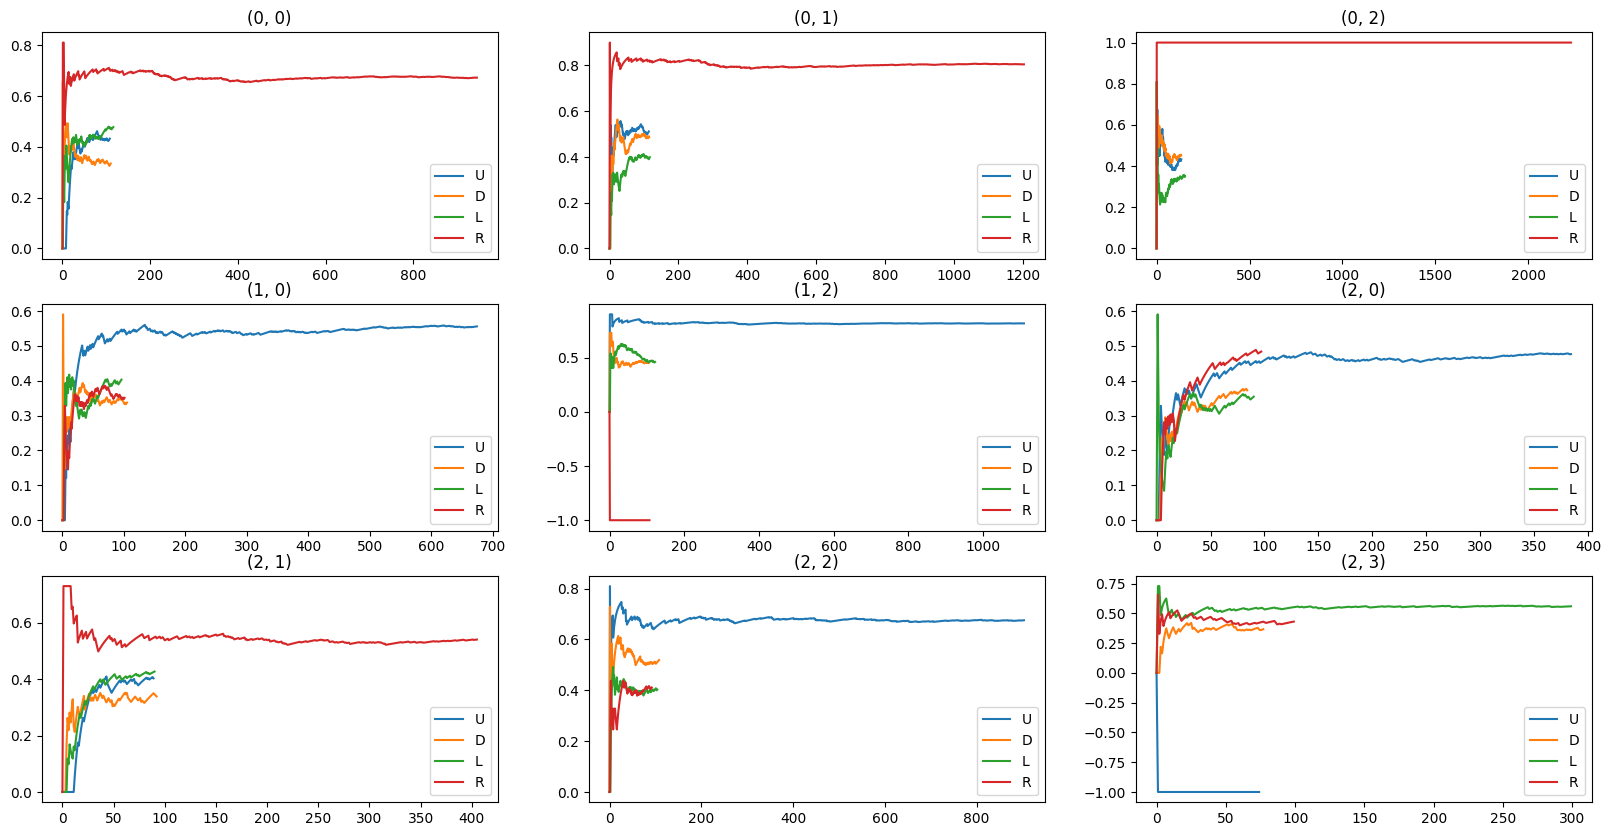

In [ ]:
plot_result(Q_on_policy_first_visit_plot)

# on-policy incremental policy iteration (every visit)

In [ ]:
Q_on_policy_every_visit, Q_on_policy_every_visit_plot = q_builder()
rewards = np.zeros(N_EPISOD)
policy = behavior_policy(Q_on_policy_every_visit)
Nt = dic_build()
for _ in range(N_EPISOD):
    states_actions_returns = play_game(grid, policy)
    for s, a, Gt in states_actions_returns:
            q_old = Q_on_policy_every_visit[s][a]
            Nt[s][a] += 1
            Q_on_policy_every_visit[s][a] = q_old +  (Gt - q_old) / Nt[s][a]
            Q_on_policy_every_visit_plot[s][a].append(Q_on_policy_every_visit[s][a])
    policy = epsilon_greedy_policy(Q_on_policy_every_visit)

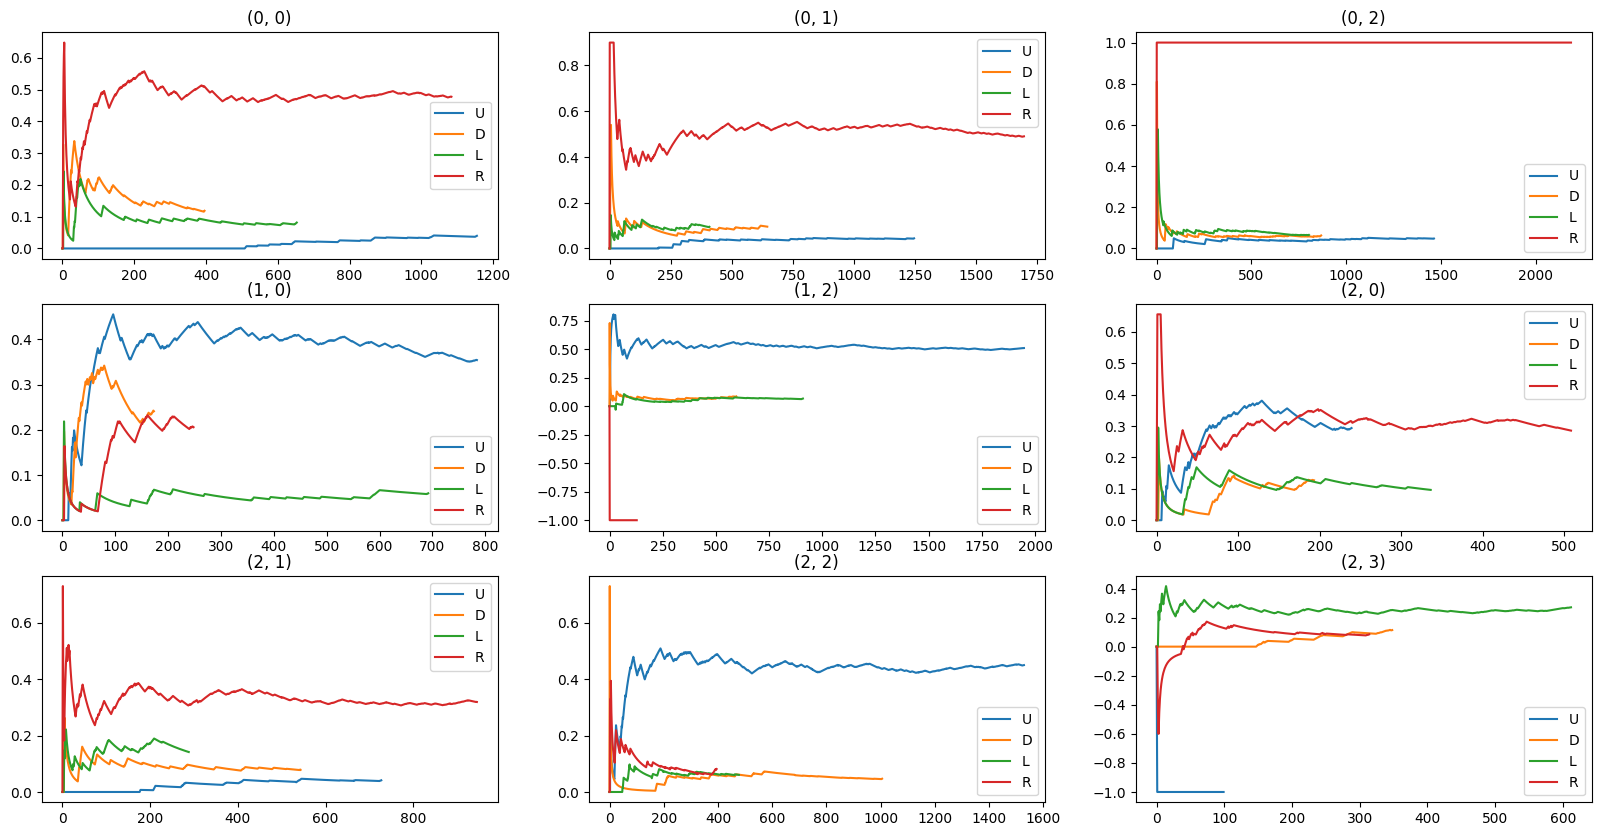

In [ ]:
plot_result(Q_on_policy_every_visit_plot)

# on-policy with learning-rate

In [ ]:
Q_on_policy_lr, Q_on_policy_lr_plot = q_builder()
rewards = np.zeros(N_EPISOD)
policy = behavior_policy(Q_on_policy_lr)
for _ in range(N_EPISOD):
    states_actions_returns = play_game(grid, policy)
    for s, a, Gt in states_actions_returns:
            q_old = Q_on_policy_lr[s][a]
            Q_on_policy_lr[s][a] = q_old + LEARNING_RATE * (Gt - q_old)
            Q_on_policy_lr_plot[s][a].append(Q_on_policy_lr[s][a])
    policy = epsilon_greedy_policy(Q_on_policy_lr)

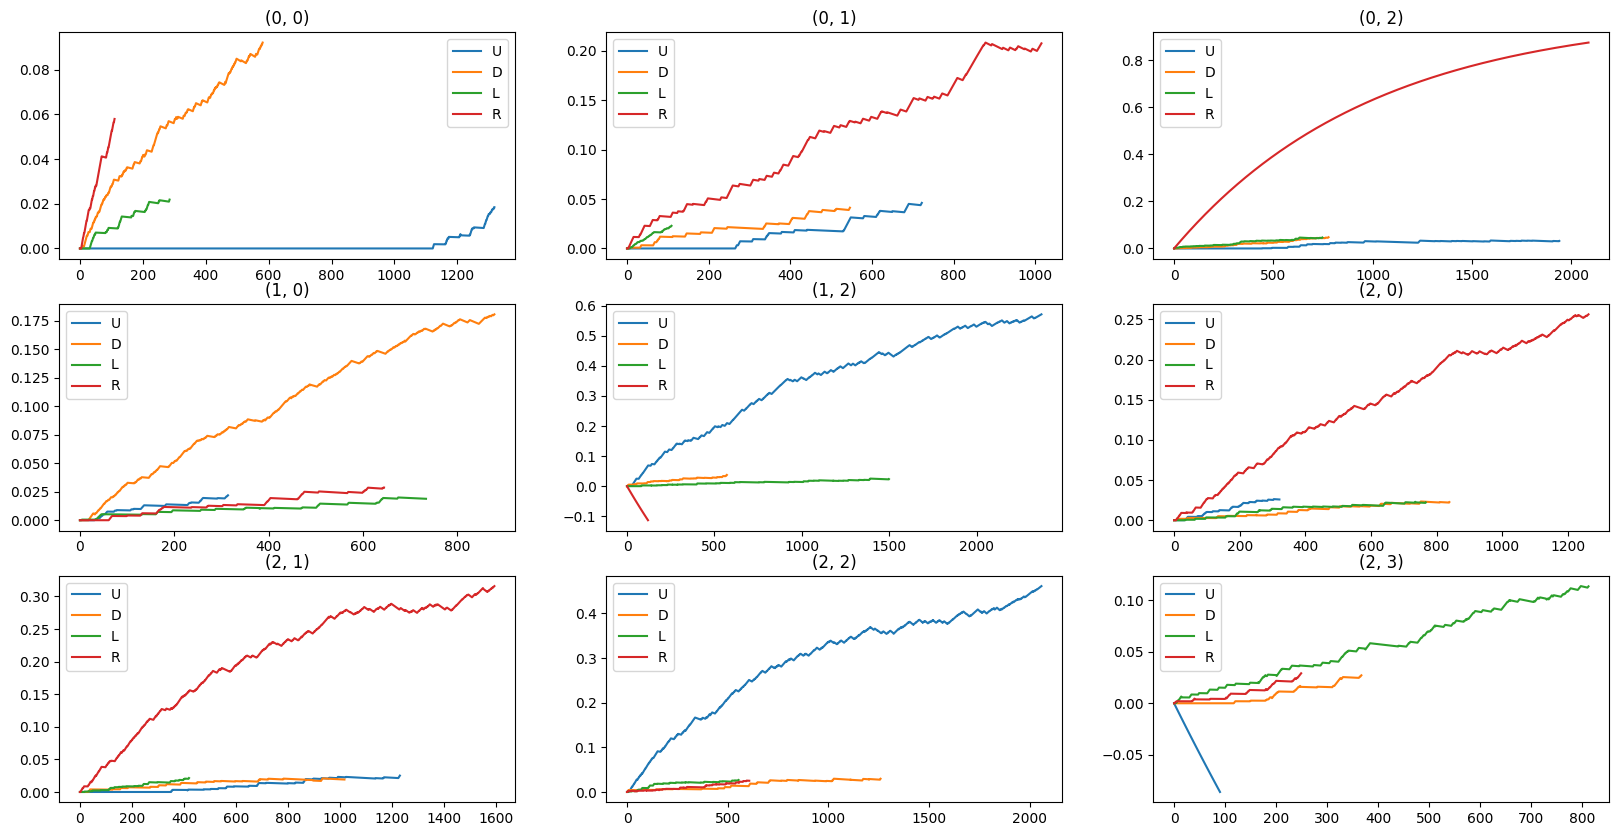

In [ ]:
plot_result(Q_on_policy_lr_plot)

# Off-policy single visit (Ordinary Importance Sampling)

In [ ]:
def play_game_off(grid, behavior_policy, target_policy):
    states = list(grid.actions.keys())
    start_idx = np.random.choice(len(states))
    current_state = states[start_idx]
    action = np.random.choice(ALL_POSSIBLE_ACTIONS)
    grid.set_state(current_state)
    state_action_rewards = [(current_state, action, 0)]
    step = 0
    while step < N_ITERATION:
        reward = grid.move(action)
        current_state = grid.current_state()
        if grid.game_over():
            state_action_rewards.append((current_state, None, reward))
            break
        action = behavior_policy[current_state]
        state_action_rewards.append((current_state, action, reward))
        step += 1

    Gt = 0
    Wt = 1
    state_action_returns = []
    first = True
    for s, a, r in reversed(state_action_rewards):
        if first:
            first = False
        else:
            state_action_returns.append((s, a, Gt, Wt))
        Gt = r + GAMMA * Gt
        if a is not None:
          if target_policy[s] == a:
            Wt = Wt * (1 / 4)
          else:
            Wt = 0
    state_action_returns.reverse()
    return state_action_returns

In [ ]:
Q_off_policy_OIS, Q_oss_policy_OIS_plot = q_builder()
rewards = np.zeros(N_EPISOD)
policy_b = behavior_policy(Q_off_policy_OIS)
policy_t = greedy_policy(Q_off_policy_OIS)
Nt = dic_build()
for _ in range(N_EPISOD):
    states_actions_returns = play_game_off(grid, policy_b, policy_t)
    for s, a, Gt, Wt in states_actions_returns:
            q_old = Q_off_policy_OIS[s][a]
            Nt[s][a] += 1
            Q_off_policy_OIS[s][a] = q_old +  Wt*(Gt - q_old) / Nt[s][a]
            Q_oss_policy_OIS_plot[s][a].append(Q_off_policy_OIS[s][a])
    policy_b = behavior_policy(Q_off_policy_OIS)
    policy_t = greedy_policy(Q_off_policy_OIS)

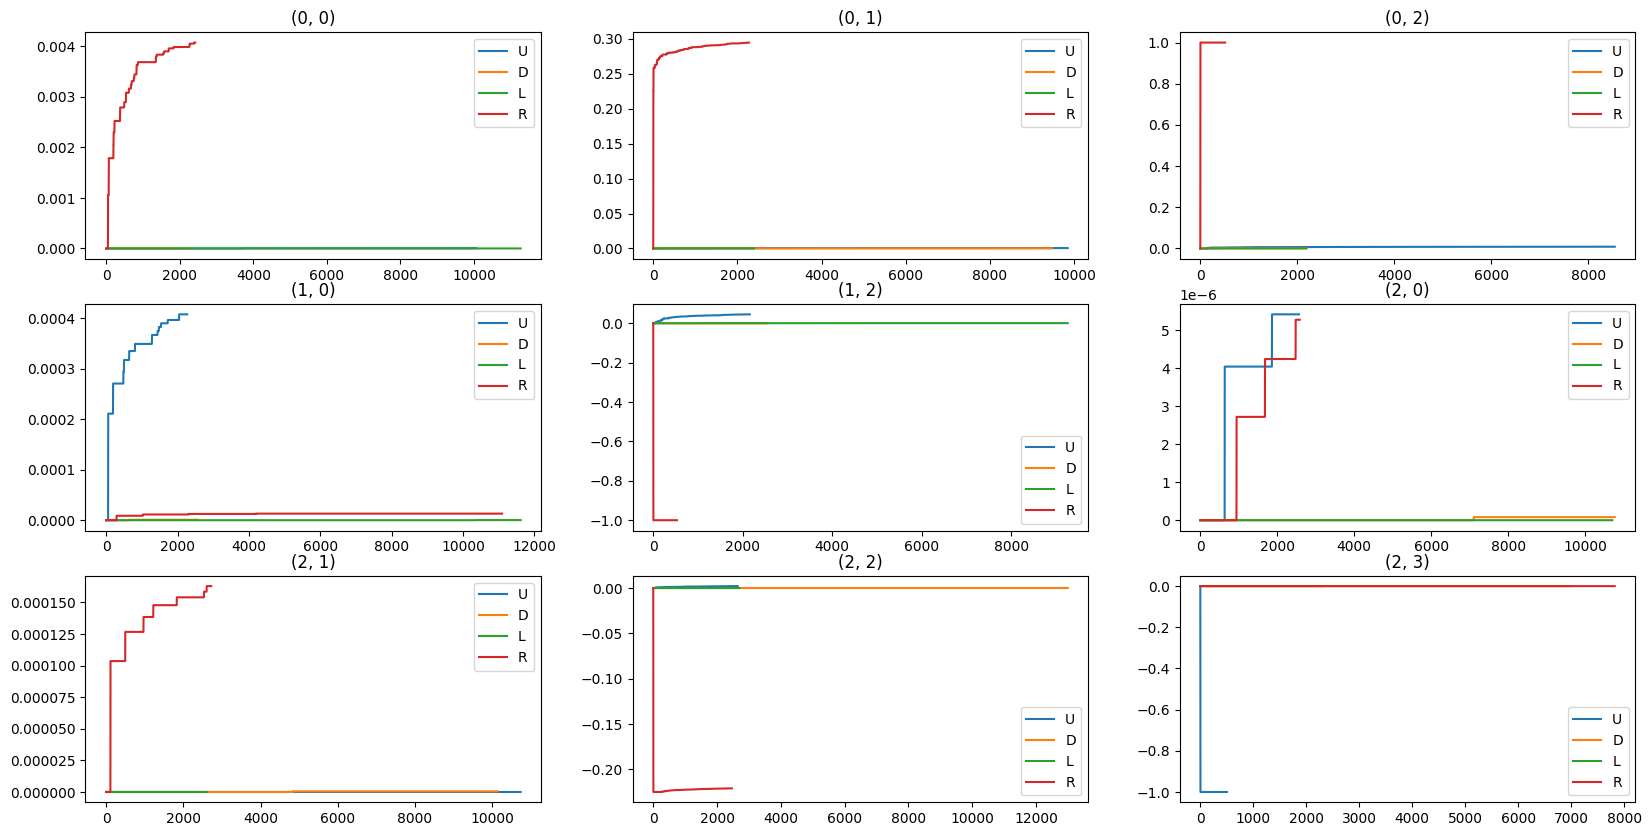

In [ ]:
plot_result(Q_oss_policy_OIS_plot)